# Work on Redshift of CosmoDC2

- author : Sylvie Dagoret-Campagne
- creation date : November 19th 2020
- last update : January 29th 2021

In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import pyarrow

In [3]:
# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=mesos://vm-75063.lal.in2p3.fr:5050 appName=PySparkShell>
2.4.4


In [4]:
from pyspark.sql.functions import col, pandas_udf 
from pyspark.sql.types import LongType

from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql import functions as F
from pyspark.sql.functions import randn

In [5]:
# here is how we create a function ('Ang2Pix') that can be called by dataframes
# it takes as input the "ra" and "dec" values (which are not very different from theta/phi)
# and returns the pixel number (but as pandas series for efficiency)
import numpy as np
import pandas as pd
import healpy as hp

nside=512

In [6]:
! hadoop dfs -ls /lsst/DC2/cosmoDC2

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Found 5 items
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-12-11 15:12 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-10-16 10:52 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_double.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-04-23 17:28 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_nofaint.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-09-07 19:17 /lsst/DC2/cosmoDC2/shear_cosmoDC2
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-04-16 18:40 /lsst/DC2/cosmoDC2/xyz_v1.1.4_hive


In [10]:
fullfilename="/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image"
datafile=fullfilename
FLAG_ONE_FILE_INPUT=True

In [11]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()

In [12]:
# Read the data as DataFrame
if FLAG_ONE_FILE_INPUT:
    df = spark.read.format("parquet").load(datafile)
else: # read all files
    #the_list_of_files=os.listdir(base_dir)
    #the_sorted_list_of_files=sorted(the_list_of_files)
    #print("sorted files : ",the_sorted_list_of_files[:5])
    #selected_files=[]
    #for filename in the_sorted_list_of_files:
    #    sel_filename=re.findall("^dc2_object_run2.2i_dr6c_tract[0-9][0-9][0-9][0-9].parquet$",filename)
    #    if len(sel_filename) > 0:
    #        selected_files.append(sel_filename[0])
    #print("selected files : ", selected_files[:5])
    #InputPath = [base_dir + "/{}".format(filename) for filename in selected_files]
    InputPath = all_files  # filename from the decoded index file
    df = spark.read.parquet(*InputPath)        

In [13]:
df.printSchema()

root
 |-- sed_2998_186_disk: float (nullable = true)
 |-- sed_17402_2596_disk: float (nullable = true)
 |-- sed_15143_2259_bulge: float (nullable = true)
 |-- Mag_true_y_lsst_z0: float (nullable = true)
 |-- sed_8329_517_bulge: float (nullable = true)
 |-- mag_i_lsst: double (nullable = true)
 |-- sed_13177_1966_disk: float (nullable = true)
 |-- mag_true_z_sdss: float (nullable = true)
 |-- sed_2407_591_no_host_extinction: float (nullable = true)
 |-- sed_1933_474_disk_no_host_extinction: float (nullable = true)
 |-- sed_3590_222: float (nullable = true)
 |-- sed_4048_251: float (nullable = true)
 |-- sed_8329_517: float (nullable = true)
 |-- mag_u_lsst_no_host_extinction: double (nullable = true)
 |-- velocity_x: double (nullable = true)
 |-- sed_1246_306_bulge: float (nullable = true)
 |-- sed_17402_2596_no_host_extinction: float (nullable = true)
 |-- sed_1552_381: float (nullable = true)
 |-- Mag_true_u_lsst_z0_no_host_extinction: float (nullable = true)
 |-- sed_6548_406_disk_no

In [14]:
rs=df.select("redshift")

In [15]:
rs.show()

+--------------------+
|            redshift|
+--------------------+
|0.021649390521782053|
|0.021912149530828096|
|0.021491185880432306|
|0.021335146372658986|
|0.006085374726386705|
| 0.00623290137713961|
|  0.0223237647522454|
|0.045172530714958414|
|0.046326508639092046|
|0.048128892222936814|
|   0.045163780350022|
|0.042040215567260786|
| 0.04728200887845091|
| 0.04620169695794596|
| 0.04155876672797998|
| 0.04503470930495679|
|0.046674333402263235|
|0.049486323344247296|
| 0.04638220212240851|
|0.046171963085680945|
+--------------------+
only showing top 20 rows



In [16]:
df.count()

324194504

In [17]:
rs.describe().show()

+-------+--------------------+
|summary|            redshift|
+-------+--------------------+
|  count|           324194504|
|   mean|  1.7477061026301262|
| stddev|  0.7008758837216199|
|    min|4.017381763912198E-4|
|    max|   3.189184186507539|
+-------+--------------------+



In [18]:
#compute only min and max of "z" (see F.min and select in DOC)
q=rs["redshift"]
rs.agg(F.min(q),F.max(q)).collect()


[Row(min(redshift)=0.0004017381763912198, max(redshift)=3.189184186507539)]

In [19]:
minmax = rs.agg(F.min("redshift"), F.max("redshift")).head()

In [20]:
minmax

Row(min(redshift)=0.0004017381763912198, max(redshift)=3.189184186507539)

# Histogram

In [21]:
#histogram caracteristics
#get the minmax values in an array: you already saw how to get the output in a dataframe.
# then you can put these values in memory with the "first()" function
minmax=rs.agg(F.min("redshift"), F.max("redshift")).head()
zmin=minmax[0]
zmax=minmax[1]
Nbins=100
dz=(zmax-zmin)/Nbins
print(zmin,zmax,dz)

0.0004017381763912198 3.189184186507539 0.03188782448331148


In [22]:
bin=rs["redshift"]-zmin

In [23]:
rs=rs.withColumn("bin", ((rs["redshift"]-zmin)/dz).astype('int'))
rs.show(20)


+--------------------+---+
|            redshift|bin|
+--------------------+---+
|0.021649390521782053|  0|
|0.021912149530828096|  0|
|0.021491185880432306|  0|
|0.021335146372658986|  0|
|0.006085374726386705|  0|
| 0.00623290137713961|  0|
|  0.0223237647522454|  0|
|0.045172530714958414|  1|
|0.046326508639092046|  1|
|0.048128892222936814|  1|
|   0.045163780350022|  1|
|0.042040215567260786|  1|
| 0.04728200887845091|  1|
| 0.04620169695794596|  1|
| 0.04155876672797998|  1|
| 0.04503470930495679|  1|
|0.046674333402263235|  1|
|0.049486323344247296|  1|
| 0.04638220212240851|  1|
|0.046171963085680945|  1|
+--------------------+---+
only showing top 20 rows



In [24]:
rs.describe(['redshift','bin']).show()

+-------+--------------------+------------------+
|summary|            redshift|               bin|
+-------+--------------------+------------------+
|  count|           324194504|         324194504|
|   mean|  1.7477061026301262| 54.29512010481214|
| stddev|  0.7008758837216199|21.981589444605728|
|    min|4.017381763912198E-4|                 0|
|    max|   3.189184186507539|                99|
+-------+--------------------+------------------+



In [25]:
# create the h dataframe using groupBy and count
h=rs.groupBy("bin").count()
# look at some values
h.show(10)

+---+-------+
|bin|  count|
+---+-------+
| 31|3833220|
| 85|3468014|
| 65|4624266|
| 53|4766192|
| 78|3937513|
| 34|4126149|
| 81|3672885|
| 28|3587912|
| 76|3977208|
| 26|3342606|
+---+-------+
only showing top 10 rows



In [26]:
#sort h (see sort or orderBy in DOC)
h=h.sort("bin")
#always check some values
h.show(5)

+---+------+
|bin| count|
+---+------+
|  0|  3870|
|  1| 28750|
|  2| 54336|
|  3|120389|
|  4|137220|
+---+------+
only showing top 5 rows



In [27]:
# add to h a column (named "loc") giving the center of the bin
h=h.withColumn("loc", zmin+dz*h["bin"]+dz/2)
h.show(5)

+---+------+--------------------+
|bin| count|                 loc|
+---+------+--------------------+
|  0|  3870| 0.01634565041804696|
|  1| 28750|0.048233474901358445|
|  2| 54336| 0.08012129938466993|
|  3|120389| 0.11200912386798141|
|  4|137220|  0.1438969483512929|
+---+------+--------------------+
only showing top 5 rows



In [28]:
# convert h to a pandas object (see toPandas in DOC)
# you may drop the "bin" column first (see drop in DOC)
p=h.toPandas()
print(p.columns,"size={}".format(p.index.size))

Index(['bin', 'count', 'loc'], dtype='object') size=100


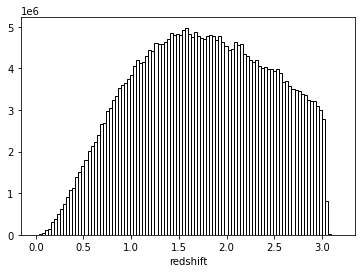

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(p['loc'].values,p['count'].values,dz,color='white',edgecolor='black')
plt.xlabel("redshift");